# Kernel Recursive Least Squares (KRLS) & Kernel Least Mean Squares

Example: Time series prediction

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from knlms import *

In [2]:
num_data = 3000
num_experiments = 200

# AWGN
v = 0.1*np.random.normal(0,1,num_data+2) 

# Initial conditions
d_true =[0.1 , 0.1]
d = [d_true[0] + v[0], d_true[1] + v[1]]

# Grab new data
new_d_true = lambda d: d.append((0.8 - 0.5 * np.exp(-(d[-1]**2)))*d[-1] - (0.3 + np.exp(-(d[-1]**2)))*d[-2] + 0.1*np.sin(np.pi*d[-1]))
for i in range(2,num_data+2):
    new_d_true(d_true)
    d.append(d_true[-1] + v[i])
d_true = d_true[2::]
d = d[2::]

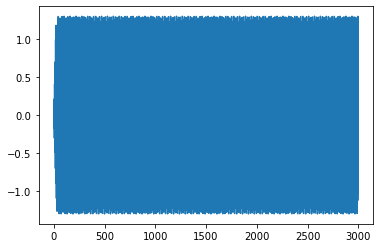

In [3]:
plt.plot(range(len(d_true)),d_true)

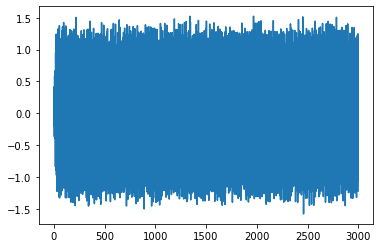

In [4]:
plt.plot(range(len(d)),d)

In [5]:

# Kernel from Richard Paper

gauss_kernel = lambda u_i,u_j: np.exp(-3.73 * (np.linalg.norm(u_i - u_j,ord=2)**2))
nmse = lambda D_n, Phi_n: np.sum((D_n - Phi_n)**2)

kernel = gauss_kernel


step_size = 0.09
reg_coeff = 0.03


threshold = 0.5
mse_KRLS = np.array([])
# Initalization
u = np.matrix([d[0],d[1]])
dictionary = np.matrix(u)
h = np.matrix(kernel(u,dictionary))
K_inv = np.matrix(1/k)

P = np.matrix(1)
alpha = np.matrix(d[0]/k)
m = 1

for n in range(1, len(d)):
    u_n = np.matrix([d[n-1],d[n]])
    d_n = np.matrix(d[n])
    
    a = K_inv @ h
    delta = kernel(u_n,u_n) - h.T @ a
    if delta > threshold:
        dictionary = np.r_[dictionary, u_n]
        K_inv = np.matrix([[delta*K_inv + a @ a.T, -a.T],
                           [-a.T, 1]])
        a = 
        P = np.matrix([[P, np.zeros((m,1))],
                       [np.zeros((m,1)).T, 1]])
        alpha = np.matrix([[alpha - a @ (d_n - h.T @ alpha)/delta],[(d_n - h.T @ alpha)/delta]])
        m = m + 1
    
    else:
        q_t = 
        P = P - ((P @ a @ a.T @ P)/(1 + a.T @ P @ a))
        alpha = alpha + K_inv @ q_t @ (d_n - h.T @ alpha)
    
    mse_KRLS = np.append(mse_KRLS, (d_true[n]-d_n + (d_n - h.T @ alpha).item())**2)
mse_KRLS_smooth = np.convolve(mse_KRLS,np.ones(20),'valid') / 20
plt.semilogy(range(len(mse_KRLS_smooth)),mse_KRLS_smooth)

SyntaxError: invalid syntax (<ipython-input-5-59ed2c331911>, line 28)

In [18]:
gauss_kernel = lambda u_i,u_j: np.exp(-3.73 * (np.linalg.norm(u_i - u_j,ord=2)**2))
kernel = gauss_kernel
u = np.matrix([d[0],d[1]])
k = np.matrix(kernel(u,u))
K_inv = np.matrix(1/k)
alpha = np.matrix(d[0]/k)
dictionary = np.matrix(u)

In [17]:
np.zeros((2,1)).T

array([[0., 0.]])

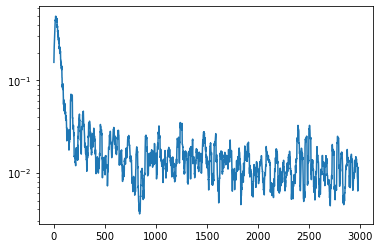

In [9]:
# KNLMS(d,d_true,kernel,step_size,reg_coeff,threshold)

In [ ]:
# KRLS

# Kernel Recursive Least Sqaures depends on a kernel functionin which to evaluate the points in a higher 
# dimension without needing to create and analyaze in the higher dimensional plane as this would create
# significant computing cost

# The use of kernel functions are valuable as they transform the data into another plane in which they become
# easy to evaluate

# for this demonstration we will be utilizing the guassian kernel function

